OSA11 charge loss model is fitted to lines at ~60 keV and 511 keV.
Trivial extrapolation of the evolution to 20 keV would lead to clear mismatch with ground calibration lines (applicable early mission) and cross-calibration obsevations (applicable late mission).

At ~22 keV there is a Cd line complex ([see](https://xdb.lbl.gov/Section1/Table_1-2.pdf)), but it's hard to use it due to several effects:
* low energy cut-off by pixel threshold. This effect appears as shift to high energy
* energy resolution. Since since the broadened line is cutoff at low energy, it unequally broadens to high energy, learing
* underlying background is very variable at low energy. Also, in this energy range, source contribution is often comparable to the background amplitude. E.g. Crab is factor ~2 higher than background.

Charge loss model, in principle, results in a prescription to how low-energy part evolves. This prescription is non-obviously different from simple linear change of offset and gain. Specifically, low-energy gain evolves slower than high-energy one.


(1e-05, 10)

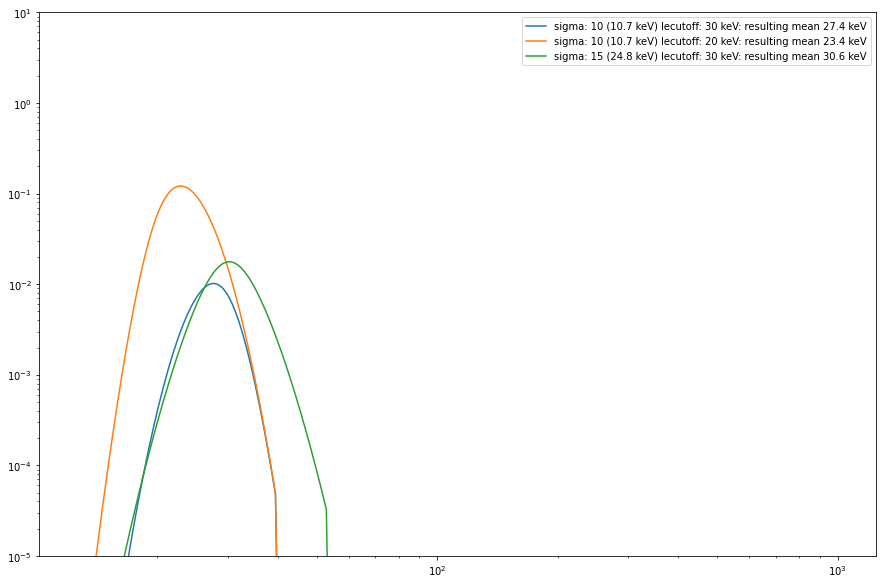

In [55]:
import numpy as np
from scipy.ndimage import gaussian_filter1d as g1d
from scipy.stats import norm
import matplotlib.pylab as plt

plt.figure(figsize=(15, 10))

en = np.logspace(1.1, 3, 300)


raw_line = norm(22, 0.1).pdf(en)

def leeffi(en, position=15, sharpness=14):
    return (en/position)**sharpness/(1+(en/position)**sharpness)

def observe(raw, sigma, lecutoff):
    return g1d(raw, sigma)*leeffi(en, lecutoff)


for sigma, lecutoff in [
    (10, 30),
    (10, 20),
    (15, 30)
]:
    obs_nole = observe(raw_line, sigma, 0.1)
    obs = observe(raw_line, sigma, lecutoff)

    mean = np.sum(en*obs)/np.sum(obs)
    width = np.nansum(obs_nole*en**2)/np.nansum(obs_nole) - (np.nansum(obs_nole*en)/np.nansum(obs_nole))**2

    plt.plot(
        en,
        obs,
        label=f"sigma: {sigma} ({width:.1f} keV) lecutoff: {lecutoff} keV: resulting mean {mean:.1f} keV"
    )


plt.loglog()
plt.legend()

plt.ylim([1e-5, 10])